# SISTEMAS DE BIG DATA - Examen 1ª Evaluación

**Instrucciones generales**

1.	Todas las sentencias deben ejecutarse desde la línea de comandos en las celdas que hay después del enunciado. No debes realizar ninguna tarea desde fuera de Jupyter.
2.	Puedes **añadir** todas las celdas que necesites siempre y cuando estén antes del siguiente enunciado.
3.	Todas las celdas **deben estar ejecutadas** y debe visualizarse el resultado de salida.
4.	**No es necesario documentar** las respuestas, simplemente debes hacer lo que se pide en el enunciado.
5.	Después de cada parte debes insertar una **captura de pantalla** del cliente gráfico de la base de datos correspondientes donde se vea que los datos se han cargado correctamente.
6.	Debes entregar tanto el **notebook** (fichero `.ipynb`) como el mismo fichero convertido a **PDF** (es muy probable que si intentas convertirlo en el propio contenedor te falle por no tener instalado `pandoc`, si es así descargalo en formato `.md` o `html` y conviértelo en tu máquina física).

---

**NOMBRE**: Daniela González Rodríguez

---

## Contexto del escenario

Has sido contratado por una fábrica inteligente que dispone de sensores de temperatura y vibración en sus máquinas críticas. La empresa necesita un sistema backend capaz de procesar los datos que llegan de los sensores en tiempo real.

El sistema debe cumplir dos objetivos simultáneos:

1.  **Monitorización en vivo (Dashboard):** los operarios necesitan saber el estado *actual* de cada máquina y si hay alguna alarma activa en este preciso instante. Para esto usarás **Redis**.
2.  **Histórico para mantenimiento predictivo:** el equipo de Data Science necesita almacenar todos los datos brutos a lo largo del tiempo para entrenar modelos de IA futuros. Para esto usarás **InfluxDB**.

## Los Datos de Entrada

Los datos con los que vas a trabajar los tienes en el *dataset* sintético adjunto llamado `sensores.csv`. Este *dataset* contiene lecturas simuladas con las siguientes columnas:

  - `timestamp`: fecha y hora del evento.
  - `machine_id`: identificador único de la máquina.
  - `zone`: zona de la fábrica.
  - `temperature`: temperatura en grados Celsius.
  - `vibration`: nivel de vibración (0-100).
  - `lat`, `lon`: coordenadas del robot.
  - `status`: estado reportado por la máquina ("OK", "WARNING", "ERROR").

**IMPORTANTE**

El desarrollo del examen debe de ser modular, con un programa principal que inicialice las conexiones a la base de datos y lea los datos del fichero y luego invocará **una función diferente para cargar cada tipo de dato** en la base de datos

Es decision tuya elegir los parámetros que recibirá cada función, aunque es altamente aconsejable **no utilizar variables globales**.

## Parte A: Persistencia histórica (InfluxDB)

`2 puntos`

En esta parte tienes que crear un script que lea el fichero CSV facilitado y almacene los datos en una base de datos InfluxDB.

Los aspectos que tienes que tener en cuenta son:

  - **Bucket:** `factory_logs`
  - **Measurement:** `maquinaria`
  - **Requisito clave:** debes modelar correctamente los datos usando adecuadamente *tags* o *fields* según el tipo de datos. Se debe respetar el `timestamp` del datos (no usar el tiempo de ingesta).

In [44]:
# Función que carga los datos en InfluxDB
!pip install influxdb

import csv

import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS, WriteOptions
from influxdb_client.client.exceptions import InfluxDBError
from urllib3.exceptions import NewConnectionError
from influxdb_client import Point

INFLUX_URL = "http://influxdb-influxdb2-1:8086"
INFLUX_TOKEN = "MyInitialAdminToken0="

print("--- Iniciando conexión a InfluxDB ---")

client = None

try:
    client = influxdb_client.InfluxDBClient(
        url=INFLUX_URL,
        token=INFLUX_TOKEN,
        org="docs"
        )
    print(f"Verificando estado de salud de InfluxDB en {INFLUX_URL}")
    health = client.health()
    
    if health.status == "pass":
        print("[INFO] ¡Conexión Exitosa!")
        print(f"[INFO] Versión del servidor: {health.version}")
        #Aqui va la logica
        write_api = client.write_api(write_options=SYNCHRONOUS)
        with open("./telemetria_agv.csv", "r") as f:
            lector = csv.DictReader(f)
            next(lector) #Saltar cabecera
            for fila in lector:
                #Recorremos las filas en forma de Diccionario
                from datetime import datetime
                fecha_original = fila["timestamp"].strip()
                fecha_obj = datetime.strptime(fecha_original, "%Y-%m-%d %H:%M:%S")
                fecha_iso = fecha_obj.isoformat()
                p = Point("maquinaria") \
                     .tag("machine_id",fila["machine_id"]) \
                     .tag("zone",fila["zone"]) \
                     .tag("status",fila["status"]) \
                     .field("temperature",float(fila["temperature"])) \
                     .field("lat",float(fila["lat"])) \
                     .field("lon",float(fila["lon"])) \
                     .field("vibration",float(fila["vibration"])) \
                     .time(fecha_iso)
                write_api.write(bucket="factory_logs",org="docs", record=p) 
                
    else:
        print(f"[Error] Conexion fallida. Estado: {health.status}")
        print(f"[INFO] Mensaje: {health.message}")
except (InfluxDBError,NewConnectionError) as e:
    print("[ERROR] Error al conectar con InfluxDB:")
    print(f" Detalle: {e}")
finally:
    if client:
        client.close()
        print("--- Conexión Cerrada ---")


--- Iniciando conexión a InfluxDB ---
Verificando estado de salud de InfluxDB en http://influxdb-influxdb2-1:8086
[INFO] ¡Conexión Exitosa!
[INFO] Versión del servidor: v2.7.12
--- Conexión Cerrada ---


## Parte B - Analítica en tiempo real con Redis

Debes crear un script que alimente las siguientes estructuras en Redis por cada dato procesado:

In [52]:
r.flushdb()

True

### 1.- Estadísticas agregadas

`1 punto`

Al procesar masivamente datos de telemetría, es costoso consultar la base de datos histórica (InfluxDB) para preguntas simples como "¿Cuál ha sido la temperatura máxima hoy en el Almacén A?". Vamos a usar Redis Hashes para mantener un marcador actualizado de estadísticas por zona.

Para cada fila procesada del CSV, debes actualizar un Hash correspondiente a la Zona (zone) donde se encuentra el robot.

- **Clave:** `stats:zone:{nombre_zona}` (Ej: stats:zone:Almacen_A, stats:zone:Recepcion...).
- **Campos:**:
    - `total_lecturas`: contador total de datos recibidos de esa zona.
    - `total_errores`: contador de cuántas veces el status ha sido "ERROR".
    - `max_temp`: La temperatura más alta registrada hasta el momento en esa zona.

In [21]:
import redis
import datetime

r = redis.Redis(host='redis-server', port=6379, db=0, decode_responses=True)

In [ ]:
# Función que genera las estadísticas agregadas



### 2.- Ranking de "puntos calientes" (Sorted Set)

`1 punto`

El jefe de planta quiere ver en una pantalla un "Top de Máquinas con mayor temperatura" ordenado de mayor a menor en tiempo real.

- **Estructura:** `Sorted Set` (ZSET)
- **Clave:** `dashboard:hottest_machines`
- **Score:** La temperatura actual (`temperature`).
- **Member:** El ID de la máquina (`machine_id`).

In [46]:
# Función que carga el sorted set

def sorted_set():
    with open("./telemetria_agv.csv", encoding="utf-8") as f:
        reader = csv.DictReader(f)

        for row in reader:
            score = float(row["temperature"])
            member = row["machine_id"]
            
            r.hset(f"dashboard:{member}", mapping={
                "member": member,
                "score": score
        })
            r.zadd("dashboard:ranking", {member: score})
            top10 = r.zrevrange("dashboard:ranking", 0, 10, withscores=True)
            for i, (member, score) in enumerate(top10, start=1):
                print(i, member, score)
sorted_set()


SyntaxError: incomplete input (2519916481.py, line 19)

### 3.- Seguimiento de flota (Geospatial)

`1 punto`

Las máquinas de este escenario son AGVs (robots móviles) que se mueven por la planta. Necesitamos saber su ubicación exacta.

- **Estructura:** `Geo`
- **Clave:** `factory:map`
- **Datos:** Usa la latitud y longitud que vienen en el CSV para posicionar el `machine_id`.

In [53]:
# Función que carga los datos geoespaciales
with open("./telemetria_agv.csv", encoding="utf-8") as f:
    reader = csv.DictReader(f)

    for row in reader:
        machine_id = row["machine_id"]
        zone = row["zone"]
        lon = float(row["lon"])
        lat = float(row["lat"])

        # Insertar coordenadas en GEOADD
        r.geoadd("factory:map", (lon, lat, machine_id))

        # Guardar nombre del POI
        r.hset("poi:info", machine_id, zone)

print(">>> Todos los POIs han sido cargados correctamente.\n")

# Ubicación del usuario (Ejemplo: Puerta del Sol)
lon_u = -3.704033
lat_u = 40.41111

# Buscar POIs en un radio de 2 km
ids = r.geosearch(
    "factory:map",
    longitude=lon_u,
    latitude=lat_u,
    radius=2000,   # 2 km
    unit="m"
)

print(f"--- POIs encontrados en 2 km: {len(ids)} ---")

for machine_id in ids:
    zone = r.hget("poi:info", machine_id)
    print(f"→ {zone} ({machine_id})")

print()

print("--- Distancias desde el usuario ---")
for poi_id in ids:
    distancia = r.geodist("factory:map", machine_id, ids[0], "km") if len(ids)>1 else None
    nombre = r.hget("poi:info", machine_id)
    print(f"{nombre}: {distancia} km (comparado con primer POI encontrado)")

print()




>>> Todos los POIs han sido cargados correctamente.

--- POIs encontrados en 2 km: 10 ---
→ Ensamblaje (AGV-10)
→ Ensamblaje (AGV-03)
→ Almacen_B (AGV-07)
→ Almacen_A (AGV-06)
→ Ensamblaje (AGV-01)
→ Recepcion (AGV-09)
→ Recepcion (AGV-08)
→ Almacen_B (AGV-02)
→ Almacen_A (AGV-04)
→ Ensamblaje (AGV-05)

--- Distancias desde el usuario ---
Ensamblaje: 0.9275 km (comparado con primer POI encontrado)
Ensamblaje: 0.9275 km (comparado con primer POI encontrado)
Ensamblaje: 0.9275 km (comparado con primer POI encontrado)
Ensamblaje: 0.9275 km (comparado con primer POI encontrado)
Ensamblaje: 0.9275 km (comparado con primer POI encontrado)
Ensamblaje: 0.9275 km (comparado con primer POI encontrado)
Ensamblaje: 0.9275 km (comparado con primer POI encontrado)
Ensamblaje: 0.9275 km (comparado con primer POI encontrado)
Ensamblaje: 0.9275 km (comparado con primer POI encontrado)
Ensamblaje: 0.9275 km (comparado con primer POI encontrado)



### 4.- Contadores globales atómicos (String)

`1 punto`

Necesitamos estadísticas rápidas que no requieran contar filas en una base de datos histórica.

- **Estructura:** `String` (Contador)
- **Clave:** `stats:total_processed` -\> Incrementar en 1 por cada fila procesada.
- **Clave:** `stats:total_errors` -\> Incrementar en 1 solo si el `status` es "ERROR".
- **Clave:** `stats:total_warnings` -\> Incrementar en 1 solo si el `status` es "WARNING".



In [ ]:
# Función que gestiona los contadores


### 5.- Cola de anomalías críticas (List)

`1 punto`

Queremos tener también una cola de anomalías críticas. Por cada registro cuyo `status` sea `ERROR` deberás crear un JSON y almacenarlo en una estructura tipo FIFO:

- **Estructura:** `List`
- **Clave:** `alerts:queue`
- **Datos:**: el JSON debe incluir: `machine_id`, `timestamp` y un mensaje: *"Critical failure at [Lat, Lon]"*.

In [ ]:
# Función que carga los datos en la cola


## Programa principal

In [ ]:
# Aquí debes insertar el programa principal que llama al resto de funciones


## Capturas de pantalla

A partir de aquí tienes que insertar las capturas de pantalla correspondientes a cada punto. Las capturas de pantalla corresponderán a la interfaz gráfica de la base de datos correspondiente y se debe mostrar que los datos se han cargado correctamente. Los apartados que no tengan la captura de pantalla correspondiente **se considerarán no realizados**.

### Captura de InfluxDB

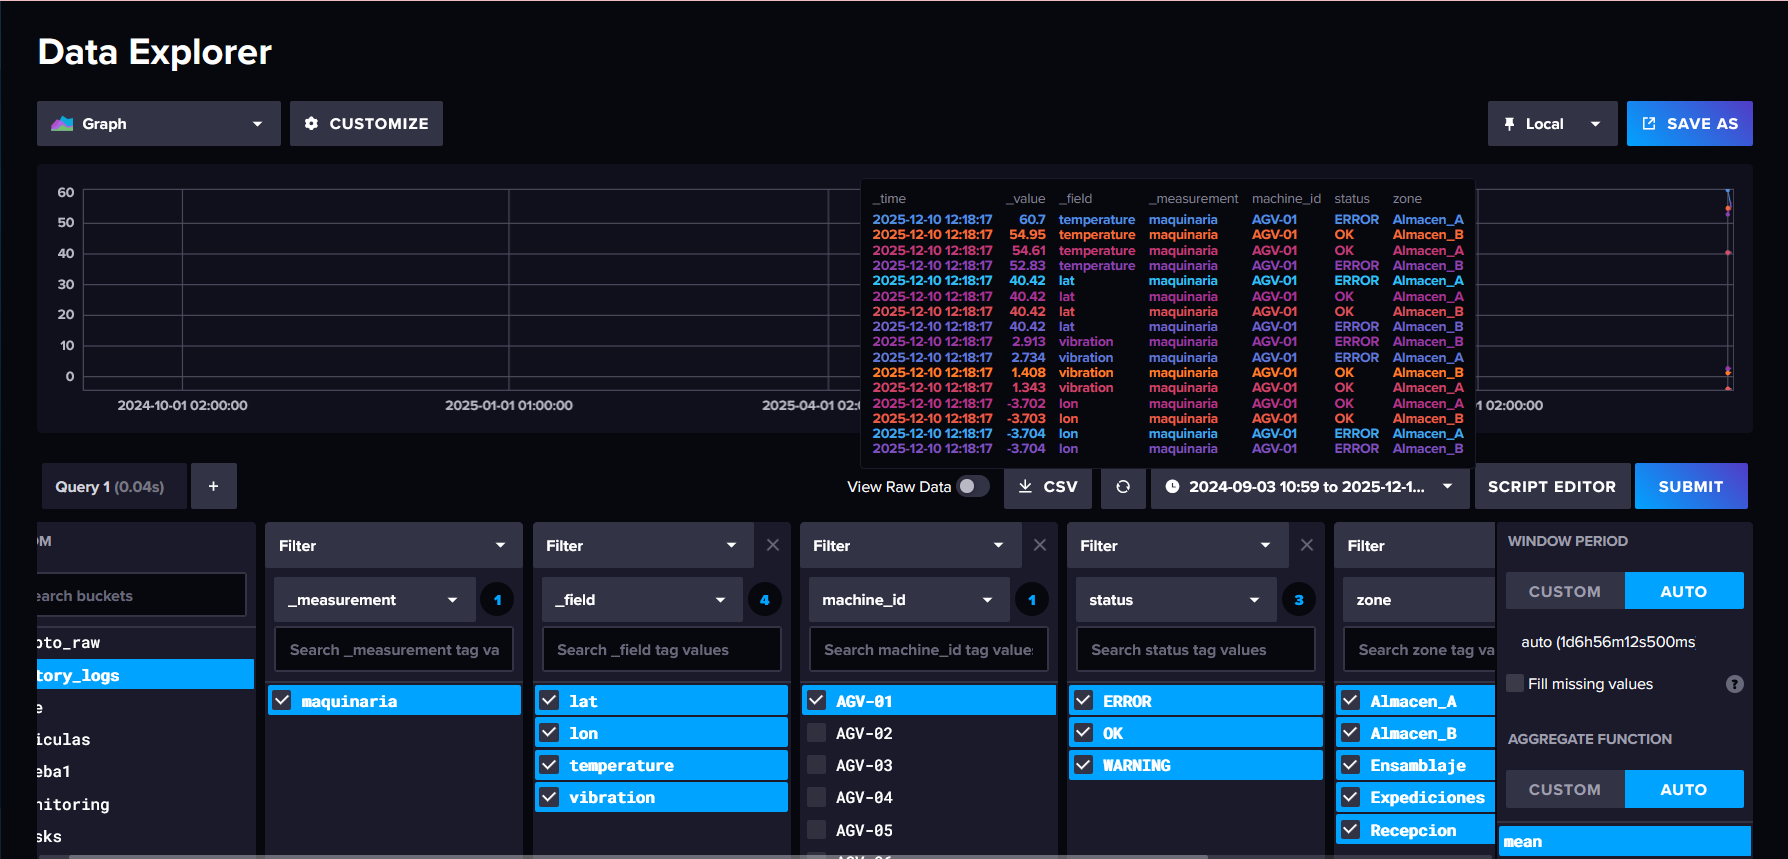

### Captura de estadísticas agregadas

### Captura de ranking de puntos calientes

### Captura de seguimiento de flota

### Captura de contadores globales atómicos

### Captura de cola de anomalías críticas